
# Linear Regression Example
The example below uses a [marketing](https://scikit-learn.org/stable/datasets/toy_dataset.html) dataset,
in order to illustrate a linear regression activity.

Workflow:



1. Preparation
    1. Load the dataset from a `.csv` file and show a short description
    1. Show the two dimensional scatter plots for all the predicting variables with respect to the target
    1. Split the data into *predicting variables* `X` and *target* `y`
        1. here we set the `random_state` variable to make the experiment *repeatable* 
1. First experiment: compute the regression on a single predicting variable
    1. Consider a reduced dataset containing the chosen variable and the target
    1. Fit the `LinearRegression` estimator on the training set
    1. Show the statistical significance of the fitted model
    1. Predict the target for the test set using the *fitted* estimator
    1. Compute the regression coefficients and the quality measures: *Root Mean Squared Error (RMSE)* and *coefficient of determination (r2)*
1. Second experiment: compute the regression considering all the predicting variables
    1. Repeat the steps from 2.2 to 2.5
1. Third experiment: use the `DecisionTreeRegressor` with the entire dataset
    1. Fit the tree using the default hyperparameters, in order to find the 
    maximum depth of the unconstrained tree
    1. Use *cross-validation* to find the optimal *maximum depth* of the tree
    1. Fit the tree with the optmal `max_depth`
    1. Predict and show the *root mean squared error*
1. Fourth experiment: use the `RandomForestRegressor`
    1. Repeat steps from 4.2 to 4.4 (for simplicity, we use the maximum `max_depth` found in 4.1)


In [1]:
# Code source: Claudio Sartori 
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split

random_state = 94922767 # this will be used to guarantee the repeatability of the experiment

## Load the dataset from a `.xlsx` file and show a short description

In [2]:
# The file must be available in the same directory, 
# or uploaded in the Colab environment 
# in the execution of the previous cell
data_fn = 'FoodUK2014.xlsx'
df0 = pd.read_excel(data_fn)

## Data Exploration and preparation

##### Show a short description of the columns

In [3]:
df0.describe()

,hhsize,adults_n,children_n,totalexp,Year,income,AgeHRP,qmeat,qfish,qfv,xmeat,xfish,xfv,uvmeat,uvfish,uvfv
count,5114.000000,5114.000000,5114.000000,5114.000000,5114.0,5114.000000,5114.000000,4873.000000,3542.000000,5017.000000,4873.000000,3542.000000,5017.000000,4873.000000,3542.000000,5017.000000
mean,2.363707,1.841807,0.521901,519.898868,2014.0,679.542002,53.802698,10.475023,2.146960,25.727801,68.108342,19.635469,58.943391,7.072523,9.934257,2.508315
std,1.244704,0.743052,0.945622,411.543093,0.0,499.596175,16.187912,8.798118,2.034353,18.371345,57.347230,18.725096,44.751694,2.931651,5.485175,1.358023
min,1.000000,0.000000,0.000000,-246.916821,2014.0,0.000000,17.000000,0.086667,0.108333,0.060667,0.195000,0.000000,0.520000,0.357694,0.000000,0.159672
25%,1.000000,1.000000,0.000000,260.598783,2014.0,306.954000,41.000000,4.452500,0.866667,12.222167,29.141668,6.917083,27.148333,5.171614,5.979375,1.760525
50%,2.000000,2.000000,0.000000,426.977227,2014.0,548.086000,54.000000,8.374167,1.625000,22.245817,54.708336,13.736667,49.356667,6.575851,8.804690,2.254208
75%,3.000000,2.000000,1.000000,651.003763,2014.0,925.652500,67.000000,14.005333,2.816667,35.037167,90.480003,26.000000,78.281662,8.295746,12.520942,2.893561
max,9.000000,7.000000,7.000000,5859.877186,2014.0,2134.090000,80.000000,104.589333,41.348362,169.283829,803.465027,194.869995,480.024994,40.000000,46.315834,32.666668


##### Show the number of rows with nulls

It is computed subtracting the number of rows in the dataset without nulls from the original number of rows

In [4]:
print(len(df0) - len(df0.dropna()))

1668


#### Drop rows with nulls

In [5]:
df1 = df0.dropna()
print(f'After dropping rows with nulls the dataset has {len(df1)} rows')

After dropping rows with nulls the dataset has 3446 rows


##### Data transormation
- Convert the alphanumeric SexHRP into numeric 0 and 1
    - the `sklearn` machine learning procedures work only with numeric predicting
      attributes
- Generate two new columns as ratio of other columns
    - this is suggested by background information

In [6]:
df1['SexHRP'].replace(['Male','Female'], [1, 0], inplace=True)

c:\Users\merli\Anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [7]:
df1.head()

,hhsize,quarter,adults_n,children_n,totalexp,SexHRP,month,Gorx,Year,income,AgeHRP,qmeat,qfish,qfv,xmeat,xfish,xfv,uvmeat,uvfish,uvfv
1,4,July to September,2,2,737.685635,1,August,North East,2014,824.520,38,6.045000,0.650000,30.203335,53.278336,6.500000,62.833336,8.813621,10.000000,2.080344
2,2,October to December,2,0,330.775000,1,October,Northern Ireland,2014,271.925,54,11.780167,2.088667,17.032166,93.838333,28.491667,42.813335,7.965790,13.641079,2.513675
4,3,April to June,3,0,880.787157,1,April,East Midlands,2014,496.040,64,12.857000,2.903333,7.345000,73.623337,16.921667,19.261665,5.726323,5.828358,2.622419
5,4,January to March,2,2,372.275578,1,February,Wales,2014,266.530,70,35.873001,1.789667,27.378000,303.181671,28.773333,86.558327,8.451528,16.077482,3.161602
7,3,January to March,3,0,151.750522,1,January,Eastern,2014,403.180,64,12.237333,3.003000,6.742667,72.258331,26.000000,17.376667,5.904745,8.658009,2.577121


In [8]:
# Generate two new columns as ratio of other columns
df1['qmeat_hhsize_ratio'] = df1['qmeat'] / df1['hhsize']
df1['income_hhsize_ratio'] = df1['income'] / df1['hhsize']

c:\Users\merli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\merli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
df1.head()

,hhsize,quarter,adults_n,children_n,totalexp,SexHRP,month,Gorx,Year,income,...,qfish,qfv,xmeat,xfish,xfv,uvmeat,uvfish,uvfv,qmeat_hhsize_ratio,income_hhsize_ratio
1,4,July to September,2,2,737.685635,1,August,North East,2014,824.520,...,0.650000,30.203335,53.278336,6.500000,62.833336,8.813621,10.000000,2.080344,1.511250,206.130000
2,2,October to December,2,0,330.775000,1,October,Northern Ireland,2014,271.925,...,2.088667,17.032166,93.838333,28.491667,42.813335,7.965790,13.641079,2.513675,5.890083,135.962500
4,3,April to June,3,0,880.787157,1,April,East Midlands,2014,496.040,...,2.903333,7.345000,73.623337,16.921667,19.261665,5.726323,5.828358,2.622419,4.285667,165.346667
5,4,January to March,2,2,372.275578,1,February,Wales,2014,266.530,...,1.789667,27.378000,303.181671,28.773333,86.558327,8.451528,16.077482,3.161602,8.968250,66.632500
7,3,January to March,3,0,151.750522,1,January,Eastern,2014,403.180,...,3.003000,6.742667,72.258331,26.000000,17.376667,5.904745,8.658009,2.577121,4.079111,134.393333


##### Use only the columns that the experts consider interesting
This is suggested by background information

In [10]:
df2 = df1[['adults_n','children_n','SexHRP','AgeHRP','qmeat_hhsize_ratio','income_hhsize_ratio','uvmeat']]
df2.head()

,adults_n,children_n,SexHRP,AgeHRP,qmeat_hhsize_ratio,income_hhsize_ratio,uvmeat
1,2,2,1,38,1.511250,206.130000,8.813621
2,2,0,1,54,5.890083,135.962500,7.965790
4,3,0,1,64,4.285667,165.346667,5.726323
5,2,2,1,70,8.968250,66.632500,8.451528
7,3,0,1,64,4.079111,134.393333,5.904745


## Choose the target and split the data into *predicting variables* `X` and *target* `y`

In [11]:
X = df2.drop('qmeat_hhsize_ratio', axis=1)
X.head()

,adults_n,children_n,SexHRP,AgeHRP,income_hhsize_ratio,uvmeat
1,2,2,1,38,206.130000,8.813621
2,2,0,1,54,135.962500,7.965790
4,3,0,1,64,165.346667,5.726323
5,2,2,1,70,66.632500,8.451528
7,3,0,1,64,134.393333,5.904745


In [12]:
y = df2['qmeat_hhsize_ratio']
y.head()

1    1.511250
2    5.890083
4    4.285667
5    8.968250
7    4.079111
Name: qmeat_hhsize_ratio, dtype: float64

## Show the two dimensional scatter plots for all the predicting variables with respect to the target

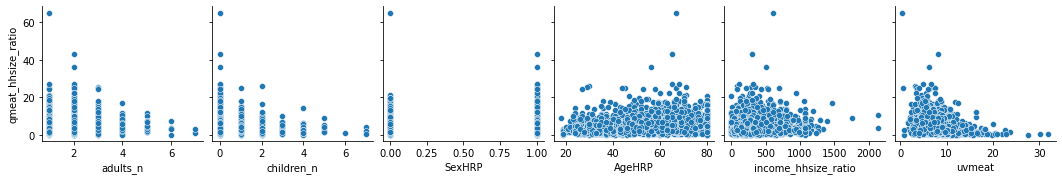

In [13]:
import seaborn as sns

sns.pairplot(df2, x_vars=X.columns, y_vars=['qmeat_hhsize_ratio']);

### Show the *_p-values_* of the target with respect to the variables

In [14]:
from sklearn.feature_selection import f_regression
# Your code here
f_statistics, p_values = f_regression(X, y)
pd.DataFrame({'features': X.columns, 'p-values': p_values})

,features,p-values
0,adults_n,1.415945e-05
1,children_n,1.077386e-30
2,SexHRP,8.429827e-02
3,AgeHRP,1.710126e-21
4,income_hhsize_ratio,1.211099e-03
5,uvmeat,4.789746e-52


## Split the data into *train* and *test* and show the sizes of the two parts
Here we set the `random_state` variable to make the experiment *repeatable*


In [15]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=random_state)
print(f'Size of training set: {len(ytrain)}, size of testing set: {len(ytest)}')


Size of training set: 2412, size of testing set: 1034


### Consider a reduced dataset containing the chosen variable and the target

In [16]:
chosen_var = 'uvmeat'
Xtrain_chosen = Xtrain[[chosen_var]]
Xtest_chosen = Xtest[[chosen_var]]

### Fit the `linear_model` estimator on the training set and predict the target for the test set using the *fitted* estimator

In [17]:
reg = linear_model.LinearRegression()
reg.fit(Xtrain_chosen, ytrain);
ypred = reg.predict(Xtest_chosen)

#### Compute the regression coefficients and the quality measures
Create a function to compute the F-statistic and p-value of the regression model

In [18]:
# Computation of F-statistic and p-value for the regression
# http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm
def quality_measures(ypred, ytrue, regressor=None):
    indices = ['rmse', 'r2', 'f-statistic', 'p-value']
    values = []
    values.append(mean_squared_error(ytrue, ypred, squared=False))
    values.append(r2_score(ytrue, ypred))
    f, p = f_regression(ypred.reshape(-1, 1), ytrue)
    values.extend([f[0], p[0]])

    if regressor is not None:
        indices.extend([f'Intercept for "{regressor.feature_names_in_[0]}"', f'Coefficient for "{regressor.feature_names_in_[0]}"'])
        values.extend([regressor.intercept_, regressor.coef_[0]])
    
    data = {'Univariate Linear - Value': values}
    return pd.DataFrame(data=data, index=indices)



#### Compute the statistical significance of the model

In [19]:
quality_measures(ypred, ytest, regressor=reg)

,Univariate Linear - Value
rmse,3.794549e+00
r2,5.391229e-02
f-statistic,6.058930e+01
p-value,1.702492e-14
"Intercept for ""uvmeat""",7.562681e+00
"Coefficient for ""uvmeat""",-3.580646e-01


## Second experiment: compute the regression considering all the predicting variables

### Now we use the entire data in `X_train` and `X_test` for fitting and predicting

In [20]:
reg2 = linear_model.LinearRegression()
reg2.fit(Xtrain, ytrain);
ypred = reg2.predict(Xtest)

### Fit, predict and show the results
Now we see the *regression coefficients* resulting from the fitting. 

In particular, *positive coefficients* indicate that the target *increases* with the variable, *negative coefficients* indicate a *decreasing* trend.

The absolute values of the coefficient cannot be considered directly a measure of importance, due to the possibly different orders of magnitude of the data in the different columns (observe above the outputs of `describe`).

In [21]:
pd.DataFrame(data={'Variable':Xtrain.columns, 'Coefficient':reg2.coef_})

,Variable,Coefficient
0,adults_n,-0.318682
1,children_n,-0.650924
2,SexHRP,0.383162
3,AgeHRP,0.014913
4,income_hhsize_ratio,0.000989
5,uvmeat,-0.392620


#### Compute the statistical significance

In [25]:
f_statistics, p_values = f_regression(Xtest, ypred)
pd.DataFrame({'features': X.columns, 'p-values': p_values})

,features,p-values
0,adults_n,3.934705e-09
1,children_n,5.199564e-106
2,SexHRP,5.279174e-03
3,AgeHRP,1.358396e-65
4,income_hhsize_ratio,2.737862e-07
5,uvmeat,1.314563e-143


#### Compute the quality measures

In [22]:
quality_measures(ypred, ytest)

,Univariate Linear - Value
rmse,3.665149e+00
r2,1.173381e-01
f-statistic,1.379652e+02
p-value,5.465084e-30


## Decision Tree Multivariate Regresson

In [27]:
# Create Decision Tree regression object
from sklearn.tree import DecisionTreeRegressor

#### Fit the tree with default hyperparameters, and find the maximum depth of the unconstrained tree

In [30]:
dtree = DecisionTreeRegressor()
dtree.fit(Xtrain, ytrain)
print(f"The maximum depth of the full Decision Tree Regressor is {dtree.tree_.max_depth}")

The maximum depth of the full Decision Tree Regressor is 34


#### Find the optimal value of the hyperparameter `max_depth` with *cross-validation*
The optimization searches for the *maximum tree depth* guaranteing the smallest mean squared error
At the end, this operation returns also the *fitted best tree* `best_estimator_`

In [46]:
from sklearn.model_selection import GridSearchCV

grid_cv = GridSearchCV(DecisionTreeRegressor(random_state=random_state), {'max_depth': list(range(2, 50))}, scoring='neg_mean_squared_error')
grid_cv.fit(Xtrain, ytrain)
best_dtree = grid_cv.best_estimator_

print(f"The optimal maximum depth for the decision tree is {best_dtree.tree_.max_depth}")

The optimal maximum depth for the decision tree is 2


In [57]:
ypred = best_dtree.predict(Xtest)
best_rmse_test = np.sqrt(mean_squared_error(ytest, ypred))
print(f"Decision Tree Regression - RMSE = {round(best_rmse_test, 3)}")

Decision Tree Regression - RMSE = 3.79


#### Show the tree

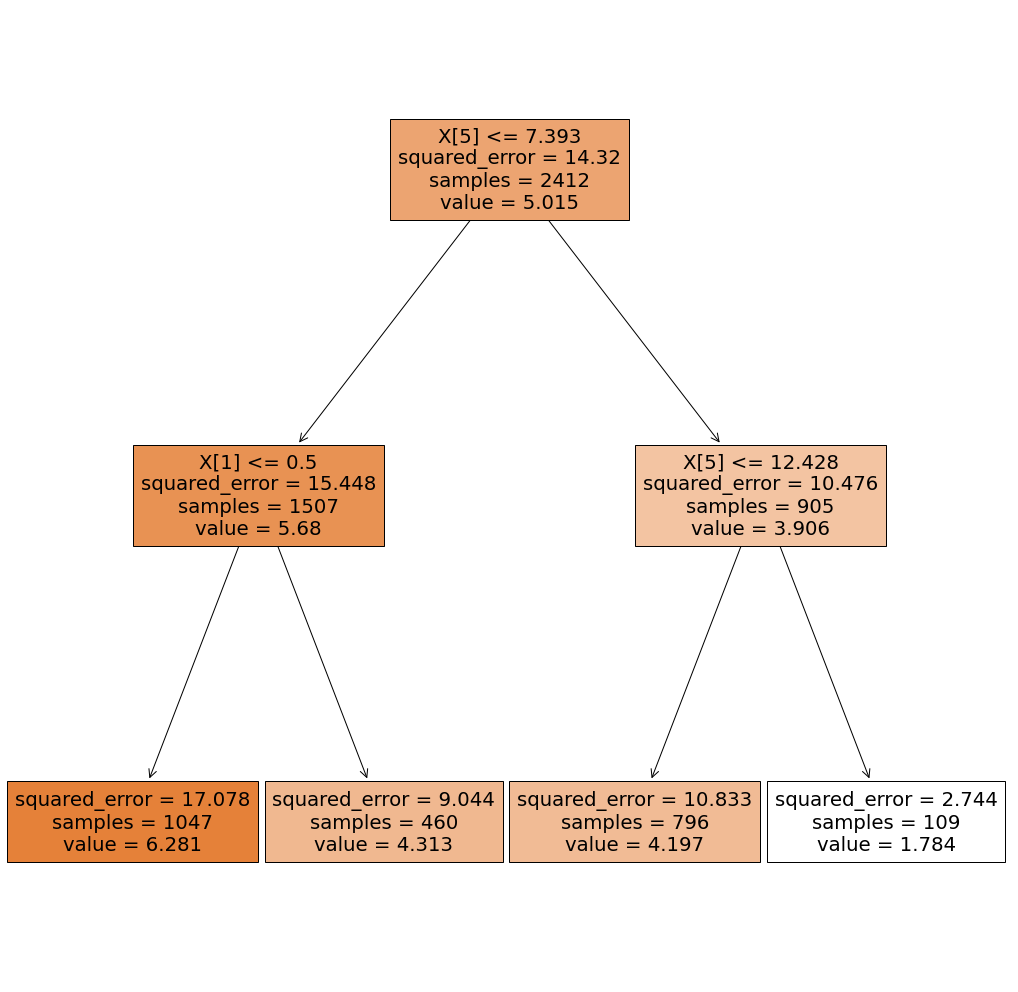

In [52]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import figure

figure(figsize=(18, 18))
plot_tree(best_dtree, filled=True);

## Random Forest Multivariate Regresson
Create a Random forest regressor and fit it on the complete dataset.

For simplicity use the max_depth found in the Decision tree regressor to perform a cross validation and find the best depth for this model.

In [67]:
from sklearn.ensemble import RandomForestRegressor

grid_cv_forest = GridSearchCV(RandomForestRegressor(random_state=random_state), {'max_depth': list(range(2, 15))}, scoring='neg_mean_squared_error')
grid_cv_forest.fit(Xtrain, ytrain)
best_forest = grid_cv_forest.best_estimator_

max_depth = -1
for t in best_forest.estimators_:
    max_depth = max(max_depth, t.tree_.max_depth)
print(f"The optimal maximum depth for the decision tree is {max_depth}")

The optimal maximum depth for the decision tree is 4


In [68]:
ypred = best_forest.predict(Xtest)
best_rmse_test = np.sqrt(mean_squared_error(ytest, ypred))
print(f"Random Forest Regression - RMSE = {round(best_rmse_test, 3)}")

Random Forest Regression - RMSE = 3.578


## Final observations
### Linear regression
The multivariate regression with all the predicting variables available with respect to the univariate regression has 
- lower RMSE 
- higher coefficient of determination 
- the p-value suggests the acceptance of both models
### Decision Tree and Random Forest regression
- Decistion Tree has an RMSE slightly higher than multivariate linear regression
- Random Forest has an RMSE slightly lower than multivariate linear regression


## Control questions
1. observing the multi-variate experiment, what variable has the higher effect on the target?
1. is there a variable having an almost negligible effect on the target?
1. try to repeat the univariate experiment with the other two columns and comment the results